In [1]:
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U datasets scipy ipywidgets matplotlib
!pip install jsonlines

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 8.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 12.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 5.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 75.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━

In [2]:
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

In [3]:
from datetime import datetime, timedelta
import yfinance as yf
import json
from google.colab import drive


# Fetching the data
ticker = "^DJI"  # Ticker symbol for Dow Jones Industrial Average
# Mount your Google Drive
from google.colab import drive
drive.mount("/content/drive")

# Change directory to where the file is saved
#%cd /content/drive/MyDrive

# Read the data from the file
import pandas as pd
data = yf.download(ticker, start="2023-01-01", end="2023-12-31")  # Example: Data for 2023

# data = pd.read_csv("data.csv")
print(data)



import json
import jsonlines

# Step 1: Download the data
# data = yf.download(tickers='GOOG', period='5d', interval='1m')

# Step 2: Convert the data to a list of dictionaries
data_list = data.to_dict('records')
#print(data_list)
# Step 3: Write the data to a .jsonl file
with open('data.jsonl', 'w') as f:
    for item in data_list:
        json.dump(item, f)
        f.write('\n')


"""
Credit for the following code is used from my partner Ethan Zhang that I am using for testing inputting into the model
"""
end_date = "2023-12-31"
start_date = "2021-1-1"
# Fetch the DJIA stock data
djia_data = yf.download(ticker, start=start_date, end=end_date)

# Convert the DataFrame to a list of dictionaries
djia_records = djia_data.reset_index().to_dict('records')
output_file = "djia_stock_data.jsonl"
with open(output_file, 'w') as f:
    pass

for i in range(7, (len(djia_records)*3) // 4):
    input_days = djia_records[i-7:i]
    output_day = djia_records[i]

    # make each input a string and each output a string with the following format:
    # input:
    # "Market Values for previous 6 days:
    # Day 1: Open:{open} High:{high} Low:{low} Close:{close} Adj Close:{adj close} Volume:{volume}, ...
    # Day 6: Open:{open} High:{high} Low:{low} Close:{close} Adj Close:{adj close} Volume:{volume}."
    # output: "Today's Market Values: Open:{open} High:{high} Low:{low} Close:{close} Adj Close:{adj close} Volume:{volume}"
    input_str = "Market Values for previous 6 days:"
    for j in range(6):
        input_str += (
            f"Day {j+1}: Open:{input_days[j]['Open']} High:{input_days[j]['High']} "
            f"Low:{input_days[j]['Low']} Close:{input_days[j]['Close']} Adj "
            f"Close:{input_days[j]['Adj Close']} Volume:{input_days[j]['Volume']}, "
            if j != 5 else
            f"Day {j+1}: Open:{input_days[j]['Open']} High:{input_days[j]['High']} "
            f"Low:{input_days[j]['Low']} Close:{input_days[j]['Close']} Adj "
            f"Close:{input_days[j]['Adj Close']} Volume:{input_days[j]['Volume']}."
        )

    output_str = (
        f"Today's Market Values: Open:{output_day['Open']} High:{output_day['High']} "
        f"Low:{output_day['Low']} Close:{output_day['Close']} Adj "
        f"Close:{output_day['Adj Close']} Volume:{output_day['Volume']}"
    )

    # create a new record with the input and output strings
    record = {"input": input_str, "output": output_str}

    # print(str(record) + "\n")

    # write the record to the JSON Lines file
    with jsonlines.open(output_file, mode='a') as writer:
        writer.write(record)


djia_records = djia_data.reset_index().to_dict('records')
output_file_eval = "djia_stock_data_eval.jsonl"
with open(output_file_eval, 'w') as f:
    pass

for i in range((len(djia_records)*3) // 4 + 7, len(djia_records)):
    input_days = djia_records[i-7:i]
    output_day = djia_records[i]

    input_str = "Market Values for previous 6 days:"
    for j in range(6):
        input_str += (
            f"Day {j+1}: Open:{input_days[j]['Open']} High:{input_days[j]['High']} "
            f"Low:{input_days[j]['Low']} Close:{input_days[j]['Close']} Adj "
            f"Close:{input_days[j]['Adj Close']} Volume:{input_days[j]['Volume']}, "
            if j != 5 else
            f"Day {j+1}: Open:{input_days[j]['Open']} High:{input_days[j]['High']} "
            f"Low:{input_days[j]['Low']} Close:{input_days[j]['Close']} Adj "
            f"Close:{input_days[j]['Adj Close']} Volume:{input_days[j]['Volume']}."
        )

    output_str = (
        f"Today's Market Values: Open:{output_day['Open']} High:{output_day['High']} "
        f"Low:{output_day['Low']} Close:{output_day['Close']} Adj "
        f"Close:{output_day['Adj Close']} Volume:{output_day['Volume']}"
    )

    # create a new record with the input and output strings
    record = {"input": input_str, "output": output_str}

    # print(str(record) + "\n")

    # write the record to the JSON Lines file
    with jsonlines.open(output_file_eval, mode='a') as writer:
        writer.write(record)


from datasets import load_dataset

train_dataset = load_dataset('json', data_files='djia_stock_data.jsonl', split='train')
eval_dataset = load_dataset('json', data_files='djia_stock_data_eval.jsonl', split='train')



Mounted at /content/drive


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


                    Open          High           Low         Close  \
Date                                                                 
2023-01-03  33148.898438  33387.519531  32850.570312  33136.371094   
2023-01-04  33165.140625  33409.101562  33033.480469  33269.769531   
2023-01-05  33191.718750  33191.718750  32812.328125  32930.078125   
2023-01-06  33055.300781  33710.660156  32997.390625  33630.609375   
2023-01-09  33664.390625  33935.109375  33487.660156  33517.648438   
...                  ...           ...           ...           ...   
2023-12-22  37349.269531  37534.519531  37268.878906  37385.968750   
2023-12-26  37405.898438  37617.988281  37371.828125  37545.328125   
2023-12-27  37518.621094  37683.699219  37488.601562  37656.519531   
2023-12-28  37661.519531  37778.851562  37650.980469  37710.101562   
2023-12-29  37701.628906  37759.429688  37538.800781  37689.539062   

               Adj Close     Volume  
Date                                 
2023-01-03  3

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [4]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [5]:
from transformers import AutoTokenizer

model = "meta-llama/Llama-2-7b-hf"
tokenizer = AutoTokenizer.from_pretrained(model, use_auth_token=True)

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/tokenization_auto.py:757: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/776 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

In [6]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "meta-llama/Llama-2-7b-hf"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config)

config.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

In [7]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

def formatting_func(example):
    print(example)
    text = f"### Input data: {example['input']}\n ### Output data: {example['output']}"
    return text


def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))

In [8]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

Map:   0%|          | 0/557 [00:00<?, ? examples/s]

{'input': 'Market Values for previous 6 days:Day 1: Open:30627.470703125 High:30674.279296875 Low:29881.8203125 Close:30223.890625 Adj Close:30223.890625 Volume:475080000, Day 2: Open:30204.25 High:30504.890625 Low:30141.779296875 Close:30391.599609375 Adj Close:30391.599609375 Volume:350910000, Day 3: Open:30362.779296875 High:31022.650390625 Low:30313.0703125 Close:30829.400390625 Adj Close:30829.400390625 Volume:500430000, Day 4: Open:30901.1796875 High:31193.400390625 Low:30897.859375 Close:31041.130859375 Adj Close:31041.130859375 Volume:427810000, Day 5: Open:31069.580078125 High:31140.669921875 Low:30793.26953125 Close:31097.970703125 Adj Close:31097.970703125 Volume:381150000, Day 6: Open:31015.369140625 High:31096.98046875 Low:30832.060546875 Close:31008.689453125 Adj Close:31008.689453125 Volume:356540000.', 'output': "Today's Market Values: Open:31084.880859375 High:31153.369140625 Low:30992.05078125 Close:31060.470703125 Adj Close:31060.470703125 Volume:413250000"}
{'input'

Map:   0%|          | 0/182 [00:00<?, ? examples/s]

{'input': 'Market Values for previous 6 days:Day 1: Open:32901.9609375 High:33291.0 Low:32901.9609375 Close:33274.1484375 Adj Close:33274.1484375 Volume:353740000, Day 2: Open:33245.78125 High:33632.8984375 Low:33245.78125 Close:33601.1484375 Adj Close:33601.1484375 Volume:311890000, Day 3: Open:33594.7890625 High:33634.71875 Low:33275.62109375 Close:33402.37890625 Adj Close:33402.37890625 Volume:283360000, Day 4: Open:33394.6015625 High:33543.83984375 Low:33376.26953125 Close:33482.71875 Adj Close:33482.71875 Volume:286660000, Day 5: Open:33420.9609375 High:33525.9609375 Low:33325.37109375 Close:33485.2890625 Adj Close:33485.2890625 Volume:258680000, Day 6: Open:33425.25 High:33590.23828125 Low:33343.4296875 Close:33586.51953125 Adj Close:33586.51953125 Volume:232920000.', 'output': "Today's Market Values: Open:33764.2109375 High:33895.4296875 Low:33593.3203125 Close:33646.5 Adj Close:33646.5 Volume:260300000"}
{'input': 'Market Values for previous 6 days:Day 1: Open:33245.78125 High:

In [9]:
max_length = 512 # This was an appropriate max length for my dataset

def generate_and_tokenize_prompt2(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt2)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt2)

Map:   0%|          | 0/557 [00:00<?, ? examples/s]

{'input': 'Market Values for previous 6 days:Day 1: Open:30627.470703125 High:30674.279296875 Low:29881.8203125 Close:30223.890625 Adj Close:30223.890625 Volume:475080000, Day 2: Open:30204.25 High:30504.890625 Low:30141.779296875 Close:30391.599609375 Adj Close:30391.599609375 Volume:350910000, Day 3: Open:30362.779296875 High:31022.650390625 Low:30313.0703125 Close:30829.400390625 Adj Close:30829.400390625 Volume:500430000, Day 4: Open:30901.1796875 High:31193.400390625 Low:30897.859375 Close:31041.130859375 Adj Close:31041.130859375 Volume:427810000, Day 5: Open:31069.580078125 High:31140.669921875 Low:30793.26953125 Close:31097.970703125 Adj Close:31097.970703125 Volume:381150000, Day 6: Open:31015.369140625 High:31096.98046875 Low:30832.060546875 Close:31008.689453125 Adj Close:31008.689453125 Volume:356540000.', 'output': "Today's Market Values: Open:31084.880859375 High:31153.369140625 Low:30992.05078125 Close:31060.470703125 Adj Close:31060.470703125 Volume:413250000"}
{'input'

Map:   0%|          | 0/182 [00:00<?, ? examples/s]

{'input': 'Market Values for previous 6 days:Day 1: Open:32901.9609375 High:33291.0 Low:32901.9609375 Close:33274.1484375 Adj Close:33274.1484375 Volume:353740000, Day 2: Open:33245.78125 High:33632.8984375 Low:33245.78125 Close:33601.1484375 Adj Close:33601.1484375 Volume:311890000, Day 3: Open:33594.7890625 High:33634.71875 Low:33275.62109375 Close:33402.37890625 Adj Close:33402.37890625 Volume:283360000, Day 4: Open:33394.6015625 High:33543.83984375 Low:33376.26953125 Close:33482.71875 Adj Close:33482.71875 Volume:286660000, Day 5: Open:33420.9609375 High:33525.9609375 Low:33325.37109375 Close:33485.2890625 Adj Close:33485.2890625 Volume:258680000, Day 6: Open:33425.25 High:33590.23828125 Low:33343.4296875 Close:33586.51953125 Adj Close:33586.51953125 Volume:232920000.', 'output': "Today's Market Values: Open:33764.2109375 High:33895.4296875 Low:33593.3203125 Close:33646.5 Adj Close:33646.5 Volume:260300000"}
{'input': 'Market Values for previous 6 days:Day 1: Open:33245.78125 High:

739


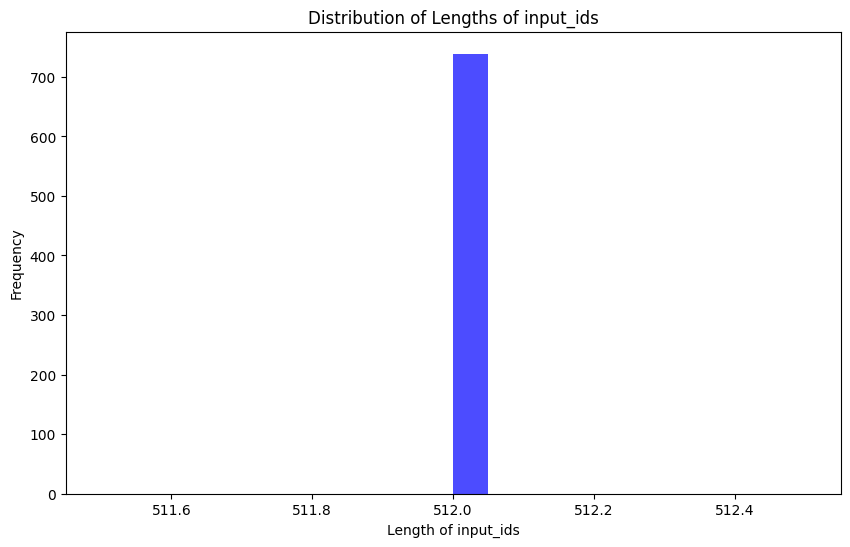

In [10]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenize_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [11]:
eval_prompt = """ Given the following financial input data, predict the output data for the closing numbers of that day

### Financial Input Data:
Market Values for previous 6 days:
Day 1: Open:33710.69921875 High:33954.7109375 Low:33582.9609375 Close:33912.44140625 Adj Close:33912.44140625 Volume:262670000,
Day 2: Open:33924.3515625 High:34281.359375 Low:33852.5703125 Close:34152.01171875 Adj Close:34152.01171875 Volume:288670000,
Day 3: Open:34029.55078125 High:34161.01171875 Low:33828.41015625 Close:33980.3203125 Adj Close:33980.3203125 Volume:281390000,
Day 4: Open:33981.859375 High:34043.828125 Low:33844.4609375 Close:33999.0390625 Adj Close:33999.0390625 Volume:282550000,
Day 5: Open:33904.69140625 High:33904.69140625 Low:33627.08984375 Close:33706.73828125 Adj Close:33706.73828125 Volume:293990000,
Day 6: Open:33586.58984375 High:33586.58984375 Low:33007.62890625 Close:33063.609375 Adj Close:33063.609375 Volume:308900000."

### Output Data:
"""

model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(tokenizer.decode(model.generate(**model_input, max_new_tokens=256, pad_token_id=2)[0], skip_special_tokens=True))

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 Given the following financial input data, predict the output data for the closing numbers of that day

### Financial Input Data:
Market Values for previous 6 days:
Day 1: Open:33710.69921875 High:33954.7109375 Low:33582.9609375 Close:33912.44140625 Adj Close:33912.44140625 Volume:262670000,
Day 2: Open:33924.3515625 High:34281.359375 Low:33852.5703125 Close:34152.01171875 Adj Close:34152.01171875 Volume:288670000,
Day 3: Open:34029.55078125 High:34161.01171875 Low:33828.41015625 Close:33980.3203125 Adj Close:33980.3203125 Volume:281390000,
Day 4: Open:33981.859375 High:34043.828125 Low:33844.4609375 Close:33999.0390625 Adj Close:33999.0390625 Volume:282550000,
Day 5: Open:33904.69140625 High:33904.69140625 Low:33627.08984375 Close:33706.73828125 Adj Close:33706.73828125 Volume:293990000,
Day 6: Open:33586.58984375 High:33586.58984375 Low:33007.62890625 Close:33063.609375 Adj Close:33063.609375 Volume:308900000."

### Output Data:
 nobody:

#include "Nobody.h"

Nobody::Nobody(int argc,

In [12]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [13]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

print(model)


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear4bit(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): Lla

In [14]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

print(model)

trainable params: 81108992 || all params: 3581521920 || trainable%: 2.264651559077991
PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
        

In [15]:
import torch

# Print the PyTorch version
print(torch.__version__)

2.2.1+cu121


In [17]:
import transformers
from datetime import datetime

project = "journal-finetune"
base_model_name = "llama2-7b"
run_name = base_model_name + "-" + project
output_dir = "./drive/MyDrive/FinGPT/" + run_name

tokenizer.pad_token = tokenizer.eos_token
trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=1,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=1,
        max_steps=500,
        learning_rate=2.5e-5, # Want a small lr for finetuning
        fp16=True,
        optim="paged_adamw_8bit",
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=100,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=50,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training

    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1449: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
50,No log,0.581829
100,No log,0.562476
150,No log,0.559673
200,No log,0.553686
250,No log,0.555135
300,No log,0.556418
350,No log,0.557179
400,No log,0.555965
450,No log,0.558497
500,0.547900,0.559045


/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:177: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:177: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in

TrainOutput(global_step=500, training_loss=0.5478696899414063, metrics={'train_runtime': 1015.1186, 'train_samples_per_second': 0.985, 'train_steps_per_second': 0.493, 'total_flos': 2.0526379485364224e+16, 'train_loss': 0.5478696899414063, 'epoch': 1.7921146953405018})

In [18]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "meta-llama/Llama-2-7b-hf"

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    quantization_config=bnb_config,  # Same quantization config as before
    device_map="auto",
    trust_remote_code=True
)

tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_bos_token=True, trust_remote_code=True)

from peft import PeftModel

ft_model = PeftModel.from_pretrained(base_model, "/content/drive/MyDrive/FinGPT/llama2-7b-journal-finetune/checkpoint-200")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [19]:
eval_prompt = """ Given the following financial input data, predict the output data for the closing numbers of that day.

### Financial Input Data:
Market Values for previous 6 days:
Day 1: Open:33710.69921875 High:33954.7109375 Low:33582.9609375 Close:33912.44140625 Adj Close:33912.44140625 Volume:262670000,
Day 2: Open:33924.3515625 High:34281.359375 Low:33852.5703125 Close:34152.01171875 Adj Close:34152.01171875 Volume:288670000,
Day 3: Open:34029.55078125 High:34161.01171875 Low:33828.41015625 Close:33980.3203125 Adj Close:33980.3203125 Volume:281390000,
Day 4: Open:33981.859375 High:34043.828125 Low:33844.4609375 Close:33999.0390625 Adj Close:33999.0390625 Volume:282550000,
Day 5: Open:33904.69140625 High:33904.69140625 Low:33627.08984375 Close:33706.73828125 Adj Close:33706.73828125 Volume:293990000,
Day 6: Open:33586.58984375 High:33586.58984375 Low:33007.62890625 Close:33063.609375 Adj Close:33063.609375 Volume:308900000."

### Output Data:

If you think the stock is worth buying, print "BUY"
"""
model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
print(ft_model.generation_config)

with torch.no_grad():
    print(tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=300)[0], skip_special_tokens=True))

GenerationConfig {
  "bos_token_id": 1,
  "do_sample": true,
  "eos_token_id": 2,
  "max_length": 4096,
  "pad_token_id": 0,
  "temperature": 0.6,
  "top_p": 0.9
}

 Given the following financial input data, predict the output data for the closing numbers of that day.

### Financial Input Data:
Market Values for previous 6 days:
Day 1: Open:33710.69921875 High:33954.7109375 Low:33582.9609375 Close:33912.44140625 Adj Close:33912.44140625 Volume:262670000,
Day 2: Open:33924.3515625 High:34281.359375 Low:33852.5703125 Close:34152.01171875 Adj Close:34152.01171875 Volume:288670000,
Day 3: Open:34029.55078125 High:34161.01171875 Low:33828.41015625 Close:33980.3203125 Adj Close:33980.3203125 Volume:281390000,
Day 4: Open:33981.859375 High:34043.828125 Low:33844.4609375 Close:33999.0390625 Adj Close:33999.0390625 Volume:282550000,
Day 5: Open:33904.69140625 High:33904.69140625 Low:33627.08984375 Close:33706.73828125 Adj Close:33706.73828125 Volume:293990000,
Day 6: Open:33586.58984375 High:33